# Projeto de Portfólio: Segmentação de Imagem com Mask R-CNN no Google Colab

#Introdução
Este notebook demonstra a implementação e execução de um modelo Mask R-CNN para segmentação de imagem. O projeto foca na detecção de objetos e na segmentação de instâncias, onde cada objeto detectado tem sua máscara pixel a pixel isolada. O modelo é executado no Google Colab, com fallback para GPU/CPU caso a TPU não esteja disponível.

### Objetivo do Projeto
* Entender o pipeline de um modelo de segmentação de instância (Mask R-CNN).
* Demonstrar a configuração de ambiente para execução em TPUs (Tensor Processing Units) e GPUs/CPUs no Google Colab.
* Realizar inferência em imagens de teste e visualizar os resultados de detecção e segmentação.
* Superar desafios de compatibilidade de versões de bibliotecas (TensorFlow, Pillow).

### Configuração do Ambiente

Esta seção prepara o ambiente do Google Colab para a execução do modelo.

1.  **Clonar o repositório oficial do Mask R-CNN:** Necessário para acessar o código-fonte do modelo e utilitários.
2.  **Instalar dependências:** `opencv-python`, `pycocotools`, `tensorflow` e `Pillow` (versão específica para compatibilidade).
3.  **Configurar o TensorFlow 1.x Compatibility:** Ajustes para rodar código TF1 em um ambiente TF2.

Célula de Código: Clone do Repositório
Clona o repositório 'tpu' do TensorFlow, que contém o código-fonte e utilitários para o Mask R-CNN.

In [ ]:
!git clone https://github.com/tensorflow/tpu/

Esta célula garante que todas as bibliotecas Python necessárias para o projeto estejam instaladas e nas versões corretas para a execução do modelo e de seus utilitários de visualização.


In [ ]:
!pip install pycocotools
!pip install tensorflow
!pip install opencv-python
!pip install Pillow==8.4.0

**Importação de Bibliotecas e Configuração de Caminhos**

Esta célula importa todas as bibliotecas Python essenciais para manipulação de imagens, operações numéricas, funcionalidades do TensorFlow e utilitários de visualização de detecção de objetos.

Além disso, ela ajusta o `sys.path` para incluir os diretórios onde os módulos do Mask R-CNN (clonados na etapa anterior) estão localizados, permitindo que o Python os encontre e os utilize.

In [ ]:
from IPython import display
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils
print(tf.__version__)

## Carregamento do Mapeamento de Índices COCO

Este Colab utiliza um *checkpoint* pré-treinado do modelo Mask R-CNN que foi treinado usando o conjunto de dados COCO (Common Objects in Context). Abaixo, você encontrará o mapeamento entre os índices numéricos que o modelo prevê e as categorias de objetos correspondentes em texto.

In [ ]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

### Carregamento e Pré-processamento da Imagem

Nesta etapa, uma imagem é carregada e preparada para ser processada pelo modelo de segmentação. O bloco de código oferece a flexibilidade de utilizar uma imagem de exemplo (baixada via `wget`) ou uma imagem carregada localmente no ambiente do Google Colab.

A imagem é lida e convertida para um formato de array de bytes (`np_image_string`) que é a entrada esperada pelo modelo. Simultaneamente, a imagem também é processada pela biblioteca PIL (Pillow) e convertida para um array NumPy (`np_image`), que é a representação em pixels utilizada para a visualização posterior.

Por fim, a imagem carregada é exibida no notebook para verificação visual antes da inferência.

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Kitano_Street_Kobe01s5s4110.jpg/2560px-Kitano_Street_Kobe01s5s4110.jpg -O test.jpg
image_path = 'test.jpg'
#image_path = '/content/imagem_2025-05-21_090631892.png' #aqui como um exemplo de imagem armazenada no colab com o diretório

with open(image_path, 'rb') as f:
  np_image_string = np.array([f.read()])

image = Image.open(image_path)
width, height = image.size
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

display.display(display.Image(image_path, width=1024))

### Verificação da Conectividade da TPU (Opcional)

Esta pequena célula de código é um utilitário de depuração que verifica se a variável de ambiente `COLAB_TPU_ADDR` está definida no ambiente do Colab. A presença dessa variável é um indicativo de que uma TPU está alocada e acessível, o que é essencial para o funcionamento do modelo quando a opção `use_tpu` está ativada.

In [ ]:
import os

if 'COLAB_TPU_ADDR' in os.environ:
    print(f"COLAB_TPU_ADDR está definida: {os.environ['COLAB_TPU_ADDR']}")
else:
    print("COLAB_TPU_ADDR NÃO está definida. O problema persiste.")

### Bloco Original de Configuração da Sessão TPU (Comentado)

Este bloco de código representa a implementação **original** para a configuração da sessão do TensorFlow com uma TPU (Tensor Processing Unit). Ele tenta se conectar diretamente à TPU verificando a variável de ambiente `COLAB_TPU_ADDR`.

In [ ]:
# use_tpu = True #@param {type:"boolean"}
# if use_tpu:
#   import os
#   import pprint

#   assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
#   TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
#   print('TPU address is', TPU_ADDRESS)

#   session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
#   print('TPU devices:')
#   pprint.pprint(session.list_devices())
# else:
#   session = tf.Session(graph=tf.Graph())

### Configuração da Sessão TensorFlow (TPU/CPU/GPU Fallback)

Esta célula é responsável por configurar a sessão do TensorFlow, que é o ambiente de execução onde o modelo será carregado e a inferência realizada. O código prioriza a conexão com uma **TPU (Tensor Processing Unit)** para aceleração de desempenho.

Caso a TPU não esteja disponível ou ocorra algum problema na conexão, um mecanismo de fallback é ativado, configurando a sessão para utilizar a **GPU** (se selecionada no tipo de ambiente de execução do Colab) ou, por último, a **CPU**. Isso garante que o modelo possa ser executado de forma robusta em diferentes configurações de hardware.

Esta implementação também incorpora as adaptações necessárias para compatibilidade com o TensorFlow 2.x, utilizando as APIs `tf.compat.v1.Session` e `tf.compat.v1.Graph` para garantir que o código TensorFlow 1.x do modelo Mask R-CNN possa funcionar corretamente.


In [ ]:
# --- Bloco de configuração do hardware ---
use_tpu = True #@param {type:"boolean"}

session = None # Inicializa a variável session

if use_tpu:
    # Tenta verificar se COLAB_TPU_ADDR está definido.
    if 'COLAB_TPU_ADDR' in os.environ:
        TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
        print(f'TPU address is: {TPU_ADDRESS}')
        try:
            # Use tf.compat.v1.Session e tf.compat.v1.Graph
            session = tf.compat.v1.Session(TPU_ADDRESS, graph=tf.compat.v1.Graph())
            print('TPU devices:')
            # Use tf.compat.v1.Session.list_devices() se list_devices() não funcionar diretamente
            pprint.pprint(session.list_devices())
            print("Usando TPU.")
        except Exception as e:
            print(f"Erro ao conectar com a TPU, usando fallback para CPU/GPU: {e}")
            # Se a conexão falhar mesmo com COLAB_TPU_ADDR, tenta CPU/GPU
            # Use tf.compat.v1.Session e tf.compat.v1.Graph
            session = tf.compat.v1.Session(graph=tf.compat.v1.Graph())
            print("Usando CPU/GPU.")
    else:
        print("COLAB_TPU_ADDR NÃO está definida. Usando fallback para CPU/GPU.")
        # Se COLAB_TPU_ADDR não estiver definida, usa CPU/GPU
        # Use tf.compat.v1.Session e tf.compat.v1.Graph
        session = tf.compat.v1.Session(graph=tf.compat.v1.Graph())
        print("Usando CPU/GPU.")
else:
    print("use_tpu está definido como False. Usando CPU/GPU.")
    # Se use_tpu for explicitamente False, usa CPU/GPU
    # Use tf.compat.v1.Session e tf.compat.v1.Graph
    session = tf.compat.v1.Session(graph=tf.compat.v1.Graph())
    print("Usando CPU/GPU.")

# Agora, 'session' estará definido e pronto para uso, seja com TPU, GPU ou CPU.
print("\nSessão TensorFlow configurada.")
# Você pode adicionar um teste para garantir que a sessão foi criada
if session:
    # Use tf.compat.v1.Session.list_devices()
    print(f"Dispositivos da sessão: {session.list_devices()}")
else:
    print("Erro: A sessão TensorFlow não foi criada.")

### Carregamento do Modelo Pré-treinado

Nesta etapa, o modelo Mask R-CNN pré-treinado é carregado para a sessão TensorFlow que foi configurada anteriormente. Este modelo é um *checkpoint* fornecido pelo Google, salvo no formato SavedModel do TensorFlow 1.x, e é otimizado para tarefas de detecção e segmentação de instâncias em imagens.


In [ ]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850' #@param {type:"string"}
_ = tf.compat.v1.saved_model.loader.load(session, ['serve'], saved_model_dir)

### Execução da Inferência e Pós-processamento dos Resultados

Este bloco de código é responsável por duas etapas cruciais:
1.  **Execução da Inferência:** A imagem pré-processada (`np_image_string`) é passada para o modelo Mask R-CNN através da sessão TensorFlow. O modelo então realiza a detecção de objetos e a geração das máscaras de segmentação. Os resultados brutos da inferência são extraídos de tensores específicos definidos pelo modelo.
2.  **Pós-processamento:** Os resultados brutos obtidos do modelo são pós-processados para serem transformados em formatos utilizáveis. Isso inclui:
    * Extrair o número de detecções.
    * Normalizar e redimensionar as caixas delimitadoras (`detection_boxes`) para as dimensões originais da imagem.
    * Organizar as pontuações de confiança (`detection_scores`), classes (`detection_classes`) e máscaras de segmentação (`instance_masks`) para cada detecção.
    * Calcular as segmentações finais no formato esperado para visualização, utilizando funções do `coco_metric`.

In [ ]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

### Visualização dos Resultados e Salvamento da Imagem

Esta célula é a etapa final no pipeline de processamento da imagem, onde os resultados da detecção de objetos e segmentação de instâncias são desenhados visualmente sobre a imagem original.

A função `visualization_utils.visualize_boxes_and_labels_on_image_array` é utilizada para sobrepor as caixas delimitadoras, rótulos de classe, pontuações de confiança e as máscaras de segmentação pixel a pixel. Os parâmetros `max_boxes_to_draw` e `min_score_thresh` permitem controlar a quantidade e a relevância das detecções exibidas.

Finalmente, a imagem com as detecções é salva em um arquivo JPEG e exibida diretamente no notebook para análise.


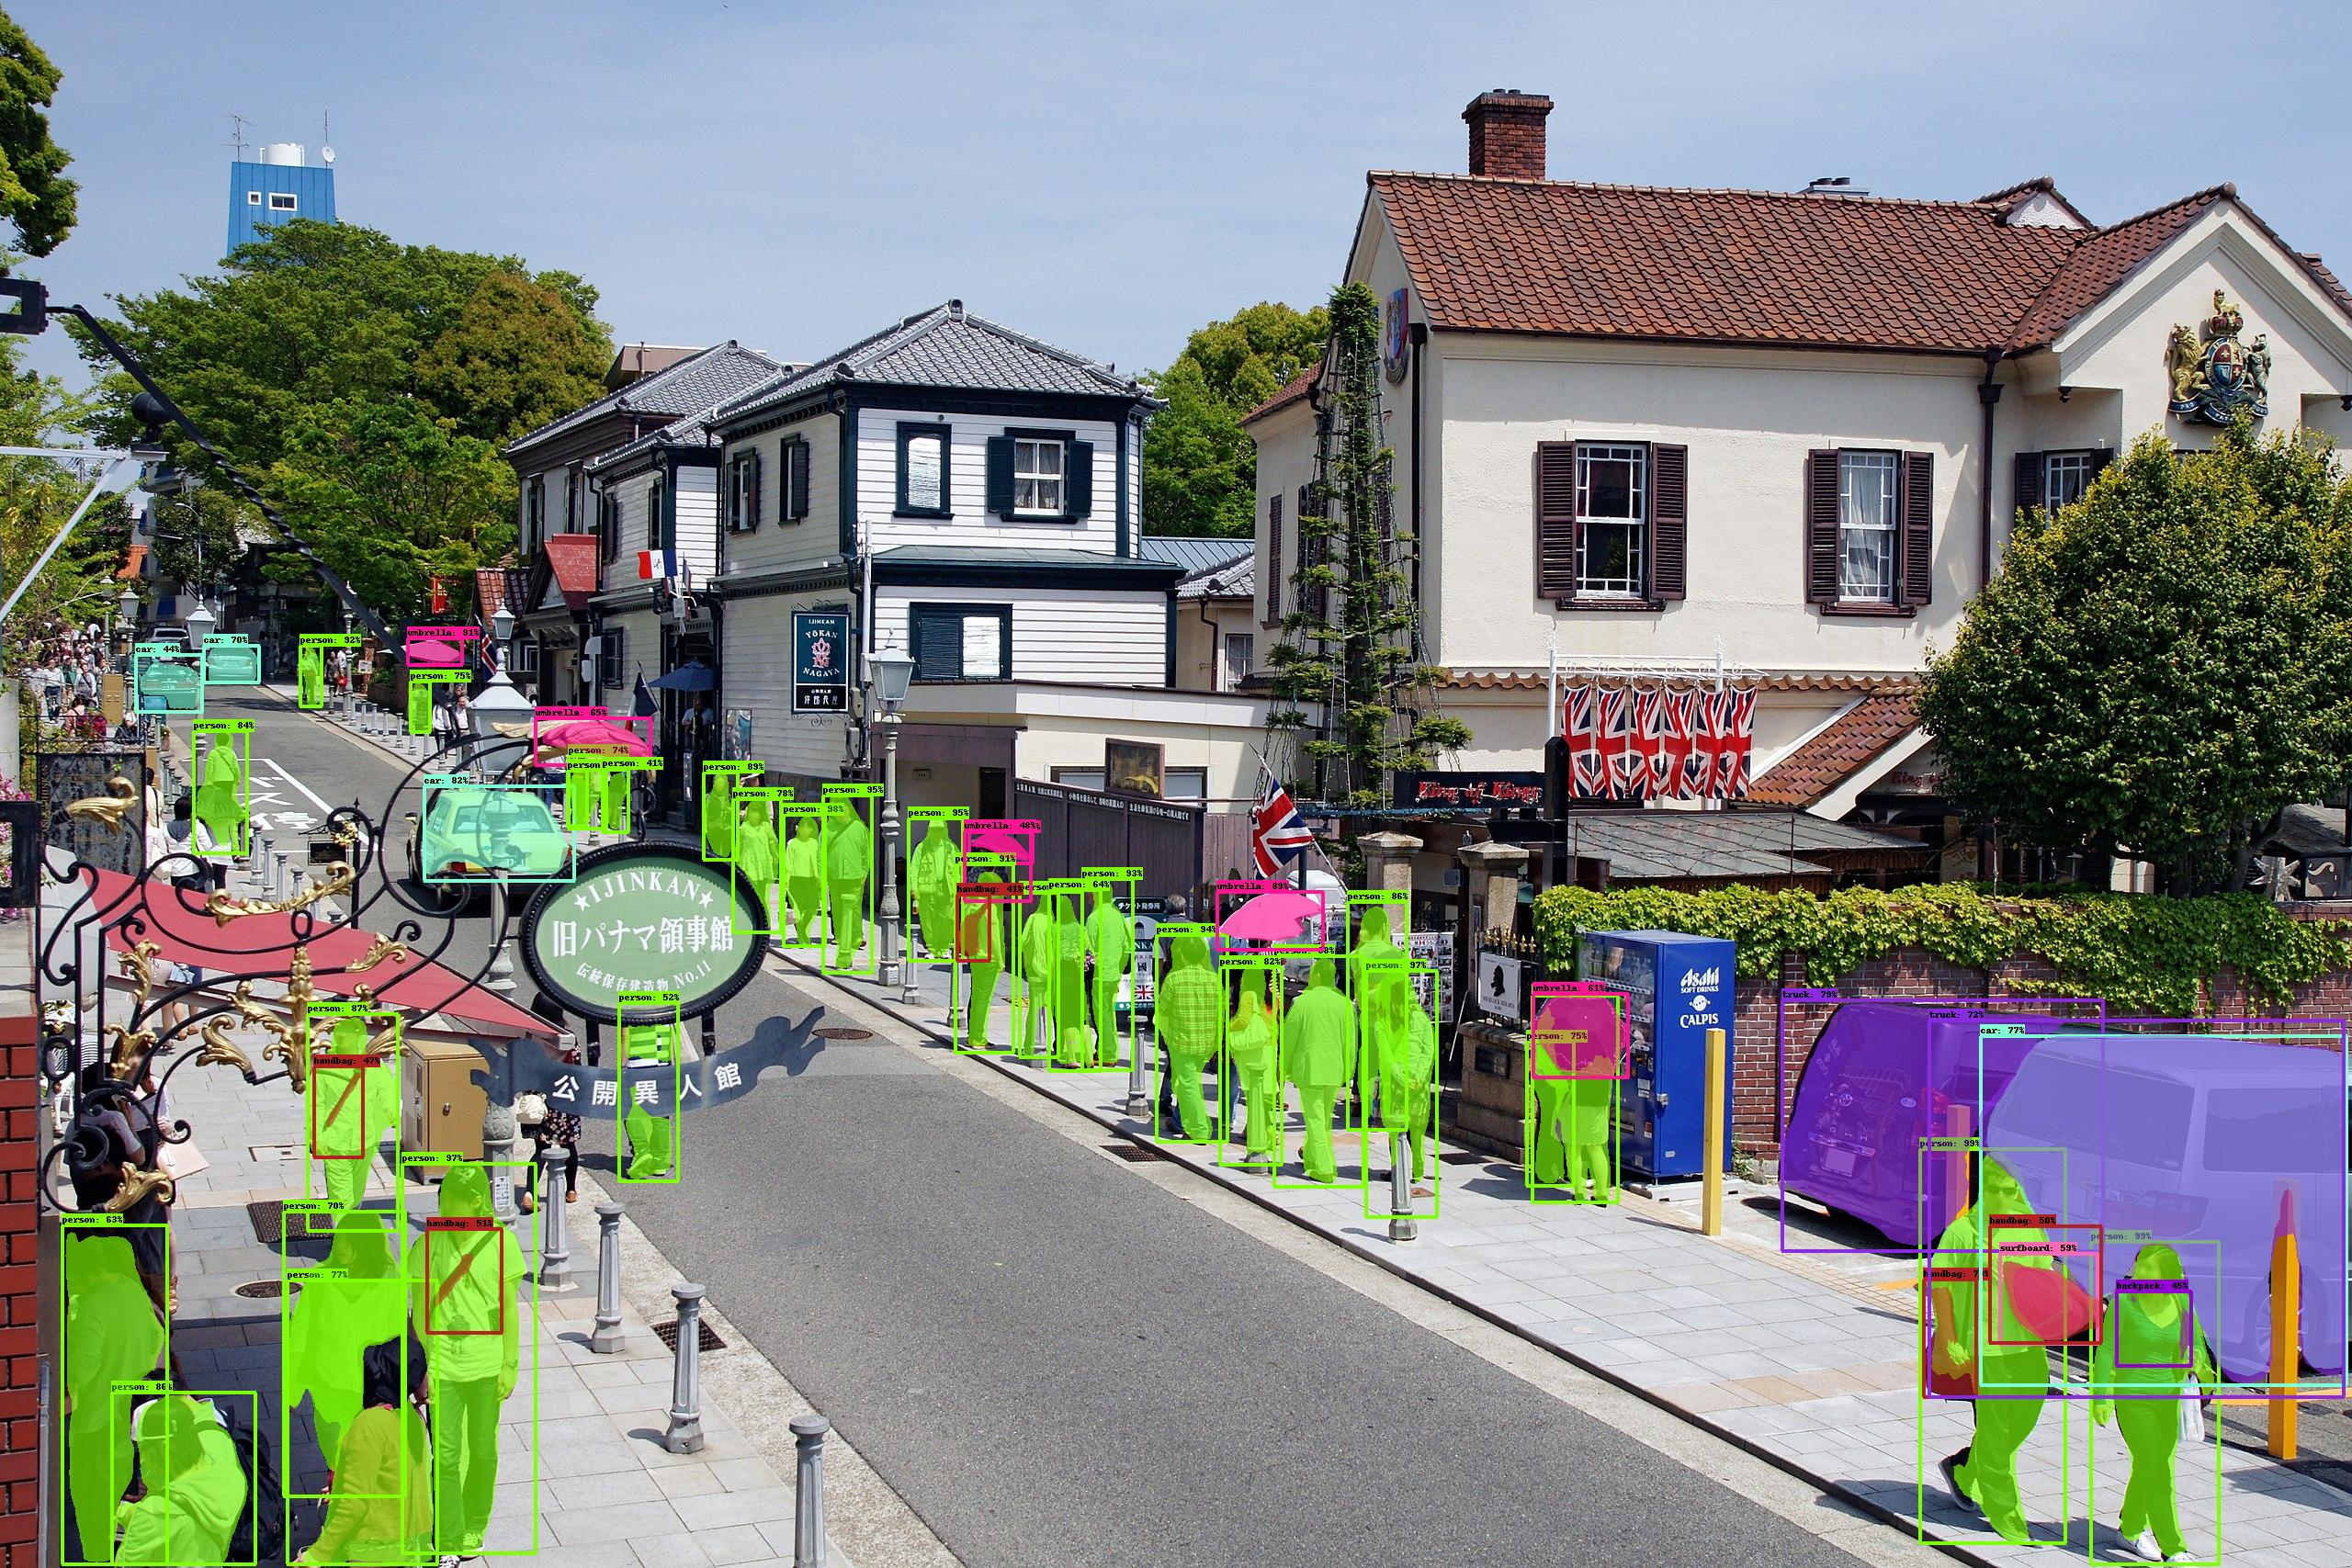

In [27]:
max_boxes_to_draw = 50   #@param {type:"integer"}
min_score_thresh = 0.1    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
output_image_path = 'test_results.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=1024))